Importing libraries and function for chunks for 10-folds

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import operator
import pandas as pd
import scipy.io as sci
%matplotlib inline
def chunk(xs, n):
    ys = list(xs)
    random.shuffle(ys)
    size = len(ys) // n
    leftovers= ys[size*n:]
    for c in xrange(n):
        if leftovers:
           extra= [ leftovers.pop() ] 
        else:
           extra= []
        yield ys[c*size:(c+1)*size] + extra

Functions for index calculation and writing them into data frame

In [2]:
def common_neighbours(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = mat[e[0]][e[1]]
    return edgesWithScore 

def salton_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 and k != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(np.sqrt(j * k))
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def jaccard_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        if nx.degree(i, e[0]) != 0 or nx.degree(i, e[1]) != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(len(set(i[e[0]])|set(i[e[1]])))
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def sorensen_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 or k != 0:
            edgesWithScore[e] = 2*float(mat[e[0]][e[1]])/float(j + k)
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def hub_promoted_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 and k != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(min(j, k))
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def hub_depressed_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 or k != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(max(j, k))
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def LHN1_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        j = nx.degree(i, e[0])
        k = nx.degree(i, e[1])
        if j != 0 and k != 0:
            edgesWithScore[e] = float(mat[e[0]][e[1]])/float(j * k)
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def preferential_attachment_index(sub):
    i = sub
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = nx.degree(i, e[0]) * nx.degree(i, e[1])
    return edgesWithScore

def adamic_adar_index(sub):
    i = sub
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = np.sum(1/np.log(nx.degree(i, sorted(nx.common_neighbors(i, e[0], e[1]))).values()))
    return edgesWithScore

def resource_allocation_index(sub):
    i = sub
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = np.sum(1/np.array(
                nx.degree(i, sorted(nx.common_neighbors(i, e[0], e[1]))).values()).astype(float))
    return edgesWithScore

def katz_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    ide = np.identity(len(mat))
    beta = (1/float(max(np.linalg.eigh(mat)[0])))/2
    sim = np.linalg.inv(ide - beta*mat) - ide
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = sim[e[0]][e[1]]
    return edgesWithScore

def lhn2_index(sub, phi = 0.1):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    ide = np.identity(len(mat))
    dma = np.diagflat(mat.sum(axis = 1))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = 0
    if np.linalg.det(dma) != 0:
        lambd = float(max(np.linalg.eigh(mat)[0]))
        sim = (2 * i.number_of_edges() * lambd * np.linalg.inv(dma)).dot(np.linalg.inv(
        ide - (phi/lambd) * mat)).dot(np.linalg.inv(dma))
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = sim[e[0]][e[1]]
    return edgesWithScore

def act_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    dma = np.diagflat(mat.sum(axis = 1))
    sim = np.linalg.pinv(dma - mat)
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        if sim[e[0]][e[0]] + sim[e[1]][e[1]] - 2*sim[e[0]][e[1]] != 0:
            edgesWithScore[e] = 1/float(sim[e[0]][e[0]] + sim[e[1]][e[1]] - 2*sim[e[0]][e[1]])
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def cbl_index(sub):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    dma = np.diagflat(mat.sum(axis = 1))
    sim = np.linalg.pinv(dma - mat)
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        if sim[e[0]][e[0]] * sim[e[1]][e[1]] != 0:
            edgesWithScore[e] = float(sim[e[0]][e[1]])/np.sqrt(sim[e[0]][e[0]] * sim[e[1]][e[1]])
        else:
            edgesWithScore[e] = 0
    return edgesWithScore

def rwr_index(sub, c = 0.5):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    dma = np.diagflat(mat.sum(axis = 1))
    sim = np.linalg.pinv(dma - mat)
    ide = np.identity(len(mat))
    pmt = np.identity(len(mat))
    es = []
    for a in i.nodes():
        e = np.zeros(len(mat))
        e[a] = 1
        es.append(e)
        for b in i.nodes():
            try:
                nx.shortest_path_length(i, source = a, target = b)
            except:
                pmt[a][b] = 0
            else:
                if nx.degree(i, a) != 0:
                    pmt[a][b] = 1/float(nx.degree(i, a))
                else:
                    pmt[a][b] = 0
    es = np.array(es)
    qs = []
    for a in i.nodes():
        if np.linalg.det(ide - c*np.transpose(pmt)) != 0:
            q = ((1 - c)*np.linalg.inv(ide - c*np.transpose(pmt))).dot(es[a])
        else:
            q = es[a]
        qs.append(q)
    qs = np.array(qs)
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = qs[e[0]][e[1]] + qs[e[1]][e[0]]
    return edgesWithScore

def matrix_forest_index(sub, alpha = 1):
    i = sub
    mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
    dma = np.diagflat(mat.sum(axis = 1))
    ide = np.identity(len(mat))
    sim = np.linalg.inv(ide + alpha*(dma - mat))
    edgesWithScore = {}
    edges = nx.non_edges(i)
    for e in edges:
        edgesWithScore[e] = sim[e[0]][e[1]]
    return edgesWithScore

def predict_nodes(G, nfolds = 10):
    df = pd.DataFrame()
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    es = nx.non_edges(subs[0])
    edges = []
    y = {}
    for e in es:
        edges.append(e)
        check = 0
        if e in folds[0]:
            check = 1
        y[e] = check
    df['Edges'] = edges
    df['y'] = df['Edges'].map(y.get)
    df['CN'] = df['Edges'].map(common_neighbours(subs[0]).get)
    df['SaI'] = df['Edges'].map(salton_index(subs[0]).get)
    df['JI'] = df['Edges'].map(jaccard_index(subs[0]).get)
    df['SoI'] = df['Edges'].map(sorensen_index(subs[0]).get)
    df['HPI'] = df['Edges'].map(hub_promoted_index(subs[0]).get)
    df['HDI'] = df['Edges'].map(hub_depressed_index(subs[0]).get)
    df['LHN1'] = df['Edges'].map(LHN1_index(subs[0]).get)
    df['PAI'] = df['Edges'].map(preferential_attachment_index(subs[0]).get)
    df['AAI'] = df['Edges'].map(adamic_adar_index(subs[0]).get)
    df['RAI'] = df['Edges'].map(resource_allocation_index(subs[0]).get)
    df['KzI'] = df['Edges'].map(katz_index(subs[0]).get)
    df['LHN2'] = df['Edges'].map(lhn2_index(subs[0]).get)
    df['ACT'] = df['Edges'].map(act_index(subs[0]).get)
    df['CBL'] = df['Edges'].map(cbl_index(subs[0]).get)
    df['RWR'] = df['Edges'].map(rwr_index(subs[0]).get)
    df['MFI'] = df['Edges'].map(matrix_forest_index(subs[0]).get)
    return df

Importing scikit learn algorithms for prediction

In [3]:
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import lda
from sklearn import qda
from sklearn import preprocessing
from sklearn import metrics
from sklearn import feature_selection
from sklearn import neural_network

Functions for accuracy calculation.
- Split edges of graph into 10 chunks
- For each chunk run indices on chunk and on compliment of graph to complete
- Build dataset of indices of edges from chunks with 'y' = 1
- Select chunks of the same size from the compliments and add their indices into dataset with 'y' = 0
- Run 10-folds on them to determine accuracies of the classificators

In [9]:
from sklearn import cross_validation
from scipy import interp
def run_10_fold_on_G(G, nfolds = 10):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    frames = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        sub = graph.copy()
        df = pd.DataFrame()
        es = nx.non_edges(sub)
        edges = []
        y = {}
        for e in es:
            edges.append(e)
            if e in folds[i]:
                y[e] = 1
            else:
                y[e] = 0
        df['Edges'] = edges
        df['y'] = df['Edges'].map(y.get)
        df['CN'] = df['Edges'].map(common_neighbours(sub).get)
        df['SaI'] = df['Edges'].map(salton_index(sub).get)
        df['JI'] = df['Edges'].map(jaccard_index(sub).get)
        df['SoI'] = df['Edges'].map(sorensen_index(sub).get)
        df['HPI'] = df['Edges'].map(hub_promoted_index(sub).get)
        df['HDI'] = df['Edges'].map(hub_depressed_index(sub).get)
        df['LHN1'] = df['Edges'].map(LHN1_index(sub).get)
        df['PAI'] = df['Edges'].map(preferential_attachment_index(sub).get)
        df['AAI'] = df['Edges'].map(adamic_adar_index(sub).get)
        df['RAI'] = df['Edges'].map(resource_allocation_index(sub).get)
        df['KzI'] = df['Edges'].map(katz_index(sub).get)
        df['LHN2'] = df['Edges'].map(lhn2_index(sub).get)
        df['ACT'] = df['Edges'].map(act_index(sub).get)
        df['CBL'] = df['Edges'].map(cbl_index(sub).get)
        df['RWR'] = df['Edges'].map(rwr_index(sub).get)
        df['MFI'] = df['Edges'].map(matrix_forest_index(sub).get)
        df = df.fillna(0)
        frames.append(df)
        #print 'Done in fold', i+1
    return frames, folds

def run_indices_on_compl(sub, fold):
    df = pd.DataFrame()
    es = nx.non_edges(sub)
    edges = []
    y = {}
    for e in es:
        edges.append(e)
        if e in fold:
            y[e] = 1
        else:
            y[e] = 0
    df['Edges'] = edges
    df['y'] = df['Edges'].map(y.get)
    df['CN'] = df['Edges'].map(common_neighbours(sub).get)
    df['SaI'] = df['Edges'].map(salton_index(sub).get)
    df['JI'] = df['Edges'].map(jaccard_index(sub).get)
    df['SoI'] = df['Edges'].map(sorensen_index(sub).get)
    df['HPI'] = df['Edges'].map(hub_promoted_index(sub).get)
    df['HDI'] = df['Edges'].map(hub_depressed_index(sub).get)
    df['LHN1'] = df['Edges'].map(LHN1_index(sub).get)
    df['PAI'] = df['Edges'].map(preferential_attachment_index(sub).get)
    df['AAI'] = df['Edges'].map(adamic_adar_index(sub).get)
    df['RAI'] = df['Edges'].map(resource_allocation_index(sub).get)
    df['KzI'] = df['Edges'].map(katz_index(sub).get)
    df['LHN2'] = df['Edges'].map(lhn2_index(sub).get)
    df['ACT'] = df['Edges'].map(act_index(sub).get)
    df['CBL'] = df['Edges'].map(cbl_index(sub).get)
    df['RWR'] = df['Edges'].map(rwr_index(sub).get)
    df['MFI'] = df['Edges'].map(matrix_forest_index(sub).get)
    df = df.fillna(0)
    return df

def get_folds_test(G, fname, name,alg = 'rf', nfolds = 10):
    f1s = []
    precisions = []
    recalls = []
    rocaucs = []
    accuracies = []
    avg_prcs = []
    random.seed(0)
    frames, folds = run_10_fold_on_G(G)
    edges = []
    for e in nx.non_edges(G):
        edges.append(e)
    zeros = [i for i in chunk(edges, len(edges)/len(folds[0]))]
    zeros = zeros[:10]
    #for j in xrange(nfolds):
    #    test_dataset = frames[j]
    #    train_dataset = pd.concat(frames[:j] + frames[(j+1):])
    #    y_train = np.array(train_dataset['y'])
    #    X_train = np.nan_to_num(
    #        np.array(train_dataset[list(set(train_dataset.columns) - set(['y', 'Edges']))]).astype('float32'))
    #    X_train = preprocessing.normalize(X_train, norm = 'l2')
    #    rf = ensemble.RandomForestClassifier(class_weight = 'auto')
    #    rf.fit(X_train, y_train)
    #    X_test = np.nan_to_num(
    #        np.array(test_dataset[list(set(test_dataset.columns) - set(['y', 'Edges']))]).astype('float32'))
    #    X_test = preprocessing.normalize(X_test, norm = 'l2')
    #    y_test = np.array(test_dataset['y'])
    #    print 'cr on test for fold', j+1
    #    y_pred = rf.predict(X_test)
    #    print classification_report(y_test, y_pred)
    #    f1s.append(metrics.f1_score(y_test, y_pred))
    #    precisions.append(metrics.precision_score(y_test, y_pred))
    #    recalls.append(metrics.recall_score(y_test, y_pred))
    #    rocaucs.append(metrics.roc_auc_score(y_test, y_pred))
    #    accuracies.append(metrics.accuracy_score(y_test, y_pred))
    #    avg_prcs.append(metrics.average_precision_score(y_test, y_pred))
    train_dataset = pd.concat([(i[i['y'] == 1]) for i in frames])
    zero_set = pd.DataFrame()
    for i in xrange(len(zeros)):
        #print zeros[i]
        #zed = []
        #for e in zeros[i]:
        #    zed.append(frames[i][frames[i]['Edges'] == e])
        #z = pd.concat(zed)
        z = frames[i][[(j in zeros[i]) for j in frames[i]['Edges']]]
        zero_set = pd.concat([zero_set, z])
    #print zero_set
    #print train_dataset
    train_dataset = pd.concat([train_dataset, zero_set])
    train_dataset.to_csv('pua.csv')
    y = np.array(train_dataset['y'])
    cv = cross_validation.StratifiedKFold(y, 10)
    X = np.nan_to_num(
        np.array(train_dataset[list(set(train_dataset.columns) - set(['y', 'Edges']))]).astype('float32'))
    #X = preprocessing.normalize(X, norm = 'l2')
    scores = []
    
    plt.figure(figsize = (6, 6))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Receiver operating characteristic for {} network".format(name))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    
    rf = ensemble.RandomForestClassifier(class_weight = 'auto')
    scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train, test) in enumerate(cv):
        probas_ = rf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'r--', label='RF Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    print 'Random Forest:'
    print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    
    
    rf = svm.SVC(kernel = 'linear', class_weight = 'auto', probability = True, max_iter = 10000)
    scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train, test) in enumerate(cv):
        probas_ = rf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'g--', label='SVM Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    print 'SVM with linear kernel:'
    print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    #rf = neural_network.BernoulliRBM()
    #scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    #print 'Neurnet:'
    #print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    #rf = svm.SVC(class_weight = 'auto')
    #scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    #print 'SVM:'
    #print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    rf = neighbors.KNeighborsClassifier()
    scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train, test) in enumerate(cv):
        probas_ = rf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'b--', label='KN Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    print 'KNN:'
    print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    rf = tree.DecisionTreeClassifier(class_weight = 'auto')
    scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train, test) in enumerate(cv):
        probas_ = rf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--', label='DT Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    print 'Decision tree:'
    print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    
    plt.legend(loc = "lower right")
    plt.savefig(fname, dpi = 300)
    plt.show()
    
    #print 'Scores:', scores
    #print "Accuracy: {:.3f} (+/- {:.3f})\n".format(scores.mean(), scores.std() * 2)
    #print 'mean infos:'
    #print 'mean F1:', np.mean(f1s)
    #print 'mean precision:', np.mean(precisions)
    #print 'mean recall:', np.mean(recalls)
    #print 'mean roc_auc:', np.mean(rocaucs)
    #print 'mean accuracy:', np.mean(accuracies)
    #print 'mean avg_precision:', np.mean(avg_prcs)

Random Forest:
Accuracy: 0.741 (+/- 0.188)

SVM with linear kernel:
Accuracy: 0.752 (+/- 0.169)

KNN:
Accuracy: 0.715 (+/- 0.211)

Decision tree:
Accuracy: 0.733 (+/- 0.263)



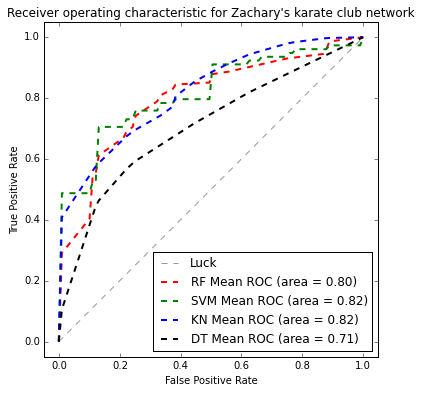

In [28]:
get_folds_test(nx.karate_club_graph(), name = "Zachary's karate club", fname = 'KC_test.png')

Random Forest:
Accuracy: 0.664 (+/- 0.095)

SVM with linear kernel:
Accuracy: 0.683 (+/- 0.088)

KNN:
Accuracy: 0.653 (+/- 0.073)

Decision tree:
Accuracy: 0.644 (+/- 0.080)



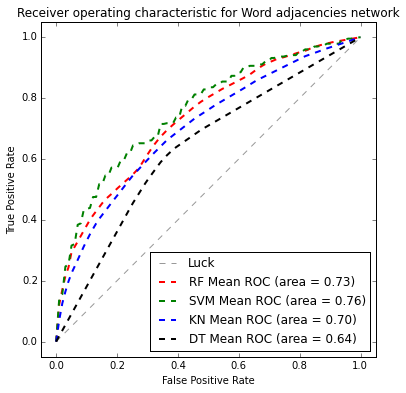

In [29]:
newman_adjnoun = nx.read_gml('./netws/newman/adjnoun/adjnoun.gml')
get_folds_test(newman_adjnoun, name = "Word adjacencies", fname = 'AN_test.png')

Random Forest:
Accuracy: 0.910 (+/- 0.039)

SVM with linear kernel:
Accuracy: 0.908 (+/- 0.030)

KNN:
Accuracy: 0.869 (+/- 0.039)

Decision tree:
Accuracy: 0.881 (+/- 0.036)



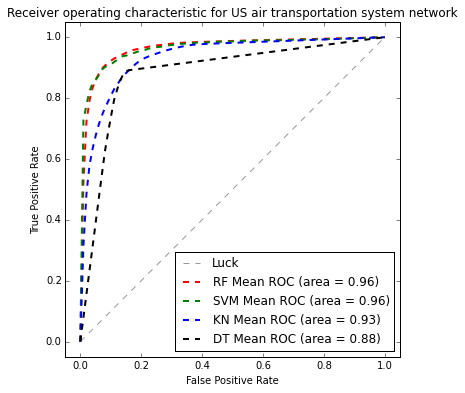

In [30]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
get_folds_test(fixed_pajek_us_air, name = "US air transportation system", fname = 'UA_test.png')

Random Forest:
Accuracy: 0.722 (+/- 0.124)

SVM with linear kernel:
Accuracy: 0.726 (+/- 0.143)

KNN:
Accuracy: 0.718 (+/- 0.108)

Decision tree:
Accuracy: 0.675 (+/- 0.095)



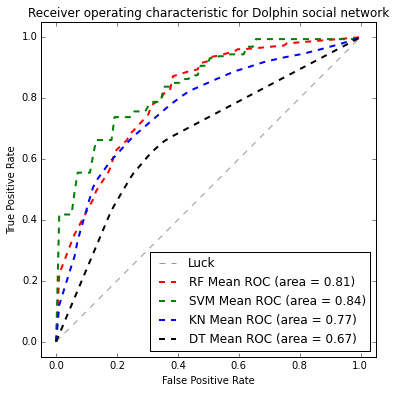

In [31]:
newman_dolphins = nx.read_gml('./netws/newman/dolphins/dolphins.gml')
fixed_newman_dolphins = nx.Graph(nx.convert_node_labels_to_integers(newman_dolphins, first_label = 0))
get_folds_test(fixed_newman_dolphins, name = "Dolphin social", fname = 'Dp_test.png')

Random Forest:
Accuracy: 0.847 (+/- 0.065)

SVM with linear kernel:
Accuracy: 0.854 (+/- 0.034)

KNN:
Accuracy: 0.837 (+/- 0.053)

Decision tree:
Accuracy: 0.793 (+/- 0.067)



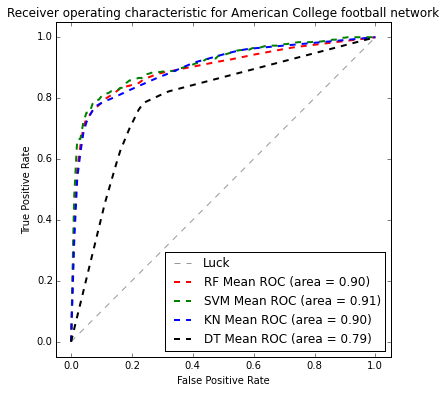

In [32]:
newman_football = nx.read_gml('./netws/newman/football/football.gml')
fixed_newman_football = nx.Graph(nx.convert_node_labels_to_integers(newman_football, first_label = 0))
get_folds_test(fixed_newman_football, name = "American College football", fname = 'FB_test.png')

Random Forest:
Accuracy: 0.870 (+/- 0.085)

SVM with linear kernel:
Accuracy: 0.876 (+/- 0.081)

KNN:
Accuracy: 0.863 (+/- 0.091)

Decision tree:
Accuracy: 0.834 (+/- 0.070)



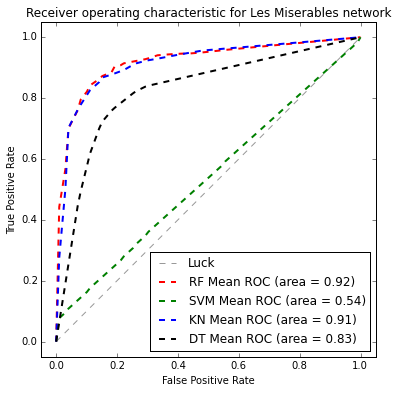

In [33]:
newman_lesmis = nx.read_gml('./netws/newman/lesmis/lesmis.gml')
fixed_newman_lesmis = nx.Graph(nx.convert_node_labels_to_integers(newman_lesmis, first_label = 0))
get_folds_test(fixed_newman_lesmis, name = "Les Miserables", fname = 'LM_test.png')

Random Forest:
Accuracy: 0.796 (+/- 0.071)

SVM with linear kernel:
Accuracy: 0.838 (+/- 0.067)

KNN:
Accuracy: 0.756 (+/- 0.042)

Decision tree:
Accuracy: 0.774 (+/- 0.071)



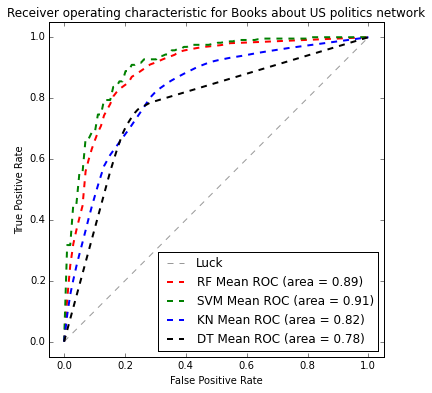

In [ ]:
newman_polbooks = nx.read_gml('./netws/newman/polbooks/polbooks.gml')
fixed_newman_polbooks = nx.Graph(nx.convert_node_labels_to_integers(newman_polbooks, first_label = 0))
get_folds_test(fixed_newman_polbooks, name = "Books about US politics", fname = 'PB_test.png')

Random Forest:
Accuracy: 0.823 (+/- 0.018)

SVM with linear kernel:
Accuracy: 0.569 (+/- 0.262)

KNN:
Accuracy: 0.763 (+/- 0.040)

Decision tree:
Accuracy: 0.771 (+/- 0.031)



C:\Anaconda2\lib\site-packages\sklearn\svm\base.py:209: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


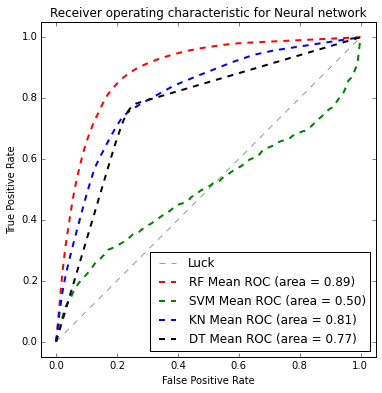

In [10]:
newman_celegansneural = nx.read_gml('./netws/newman/celegansneural/celegansneural.gml')
fixed_newman_celegansneural = nx.Graph(nx.convert_node_labels_to_integers(newman_celegansneural, first_label = 0))
get_folds_test(fixed_newman_celegansneural, name = "Neural", fname = 'CN_test.png')

In [36]:
def run_folds_alg(G, fname, name, nfolds = 10):
    f1s = []
    precisions = []
    recalls = []
    rocaucs = []
    accuracies = []
    avg_prcs = []
    
    plt.figure(figsize = (6, 6))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Receiver operating characteristic for {} network".format(name))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    feats_r = pd.DataFrame()
    feat_nm = [u'CN', u'SaI', u'JI', u'SoI', u'HPI', u'HDI', u'LHN1',
       u'PAI', u'AAI', u'RAI', u'KzI', u'LHN2', u'ACT', u'CBL', u'RWR',
       u'MFI']
    imps = []
    for i in xrange(16):
        imps.append([])
    
    random.seed(0)
    fs = [i for i in chunk(G.edges(), nfolds)]
    for i in xrange(nfolds):
        sub = G.copy()
        for e in fs[i]:
            sub.remove_edge(*e)
        frames, folds = run_10_fold_on_G(sub)
        edges = []
        for e in nx.non_edges(sub):
            edges.append(e)
        zeros = [k for k in chunk(edges, len(edges)/len(folds[0]))]
        zeros = zeros[:10]
        train_dataset = pd.concat([(k[k['y'] == 1]) for k in frames])
        zero_set = pd.DataFrame()
        for k in xrange(len(zeros)):
            z = frames[k][[(j in zeros[k]) for j in frames[k]['Edges']]]
            zero_set = pd.concat([zero_set, z])
        train_dataset = pd.concat([train_dataset, zero_set])
        y = np.array(train_dataset['y'])
        cv = cross_validation.StratifiedKFold(y, 10)
        X = np.nan_to_num(
            np.array(train_dataset[list(set(train_dataset.columns) - set(['y', 'Edges']))]).astype('float32'))
        rf = ensemble.RandomForestClassifier(class_weight = 'auto')
        #rf = svm.SVC(kernel = 'linear', class_weight = 'auto')
        #rf = svm.SVC(kernel = 'poly', class_weight = 'auto')
        #rf = tree.DecisionTreeClassifier(class_weight = 'auto')
        rf.fit(X, y)
        
        pd.set_option('precision', 4)
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        feats_r['fold_{}'.format(i)] = [(feat_nm[k], '{:.3f}'.format(importances[k])) for k in indices]
        for f in xrange(16):
            imps[f].append(importances[f])
        #print 'Feature ranking:'
        #for f in xrange(5):
            #print '{}. feature {} ({:.3f})'.format(f + 1, indices[f], importances[indices[f]])
        
        df = run_indices_on_compl(sub, fs[i])
        X_test = np.nan_to_num(np.array(df[list(set(df.columns) - set(['y', 'Edges']))]).astype('float32'))
        y_test = np.array(df['y'])
        y_pred = rf.predict(X_test)
        #print y_test
        probas_ = rf.fit(X, y).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        #print y_pred
        f1s.append(metrics.f1_score(y_test, y_pred))
        precisions.append(metrics.precision_score(y_test, y_pred))
        recalls.append(metrics.recall_score(y_test, y_pred))
        rocaucs.append(metrics.roc_auc_score(y_test, y_pred))
        accuracies.append(metrics.accuracy_score(y_test, y_pred))
        avg_prcs.append(metrics.average_precision_score(y_test, y_pred))
        #print 'Accuracy:', metrics.accuracy_score(y_test, rf.predict(X_test))
        #scores = cross_validation.cross_val_score(rf, X, y = y, cv = cv, n_jobs = -1)
        #print 'Done fold', i+1
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'b--', label='Mean ROC (area = %0.3f)' % mean_auc, lw=2)
    plt.legend(loc = "lower right")
    plt.savefig(fname, dpi = 300)
    plt.show()
    
    mean_imps = [np.mean(f) for f in imps]
    indices = np.argsort(mean_imps)[::-1]
    #feats_r['mean'] = [(feat_nm[k], '{:.3f}'.format(mean_imps[k])) for k in indices]
    feature_sort = pd.DataFrame()
    feature_sort['name'] = [feat_nm[k] for k in indices]
    feature_sort['value'] = [mean_imps[k] for k in indices]
    #print [(feat_nm[k], '{:.3f}'.format(mean_imps[k])) for k in indices]
    
    print 'infos:'
    print 'F1: {:.3f} (+/- {:.3f})'.format(np.mean(f1s), np.std(f1s))
    print 'Precision: {:.3f} (+/- {:.3f})'.format(np.mean(precisions), np.std(precisions))
    print 'Recall: {:.3f} (+/- {:.3f})'.format(np.mean(recalls), np.std(recalls))
    print 'ROC_AUC: {:.3f} (+/- {:.3f})'.format(np.mean(rocaucs), np.std(rocaucs))
    print 'Accuracy: {:.3f} (+/- {:.3f})'.format(np.mean(accuracies), np.std(accuracies))
    print 'Avg_precision: {:.3f} (+/- {:.3f})'.format(np.mean(avg_prcs), np.std(avg_prcs))
    #return feats_r
    return feature_sort

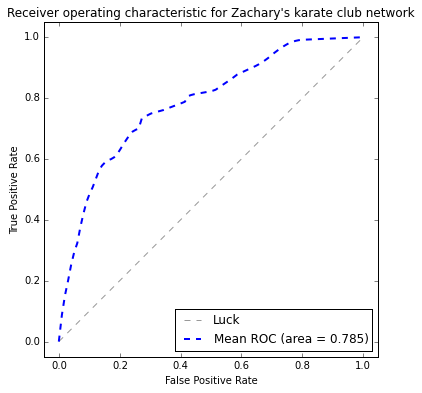

infos:
F1: 0.077 (+/- 0.020)
Precision: 0.041 (+/- 0.011)
Recall: 0.630 (+/- 0.185)
ROC_AUC: 0.696 (+/- 0.087)
Accuracy: 0.760 (+/- 0.040)
Avg_precision: 0.339 (+/- 0.096)


,name,value
0,PAI,0.130
1,SoI,0.127
2,RWR,0.127
3,ACT,0.113
4,CBL,0.093
5,KzI,0.081
6,AAI,0.055
7,RAI,0.047
8,HPI,0.041
9,HDI,0.040


In [37]:
run_folds_alg(nx.karate_club_graph(), name = "Zachary's karate club", fname = 'KC_test.png')

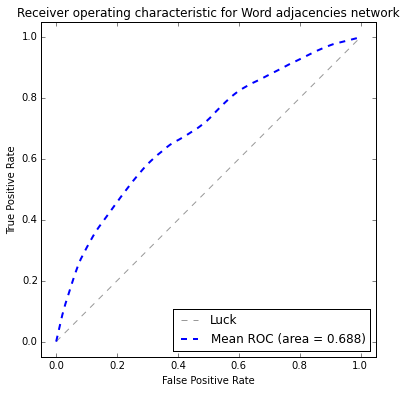

infos:
F1: 0.027 (+/- 0.004)
Precision: 0.014 (+/- 0.002)
Recall: 0.560 (+/- 0.084)
ROC_AUC: 0.633 (+/- 0.040)
Accuracy: 0.705 (+/- 0.022)
Avg_precision: 0.289 (+/- 0.042)


,name,value
0,ACT,0.165
1,RWR,0.134
2,KzI,0.129
3,CBL,0.127
4,PAI,0.114
5,SoI,0.110
6,HDI,0.040
7,AAI,0.038
8,CN,0.025
9,HPI,0.025


In [38]:
newman_adjnoun = nx.read_gml('./netws/newman/adjnoun/adjnoun.gml')
run_folds_alg(newman_adjnoun, name = "Word adjacencies", fname = 'AN_test.png')

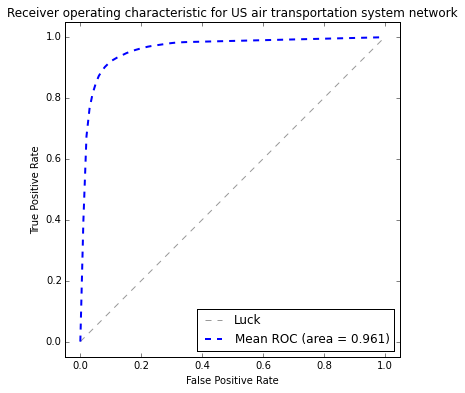

infos:
F1: 0.086 (+/- 0.006)
Precision: 0.045 (+/- 0.003)
Recall: 0.897 (+/- 0.025)
ROC_AUC: 0.910 (+/- 0.014)
Accuracy: 0.923 (+/- 0.005)
Avg_precision: 0.471 (+/- 0.014)


,name,value
0,AAI,0.224
1,HDI,0.140
2,SoI,0.133
3,PAI,0.107
4,RWR,0.072
5,ACT,0.070
6,SaI,0.059
7,LHN1,0.039
8,CBL,0.036
9,CN,0.034


In [39]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
run_folds_alg(fixed_pajek_us_air, name = "US air transportation system", fname = 'UA_test.png')

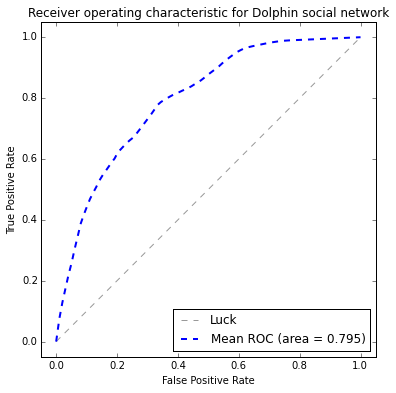

infos:
F1: 0.047 (+/- 0.010)
Precision: 0.024 (+/- 0.005)
Recall: 0.605 (+/- 0.138)
ROC_AUC: 0.690 (+/- 0.068)
Accuracy: 0.773 (+/- 0.037)
Avg_precision: 0.317 (+/- 0.070)


,name,value
0,PAI,0.167
1,SoI,0.144
2,ACT,0.140
3,RWR,0.125
4,KzI,0.079
5,CBL,0.067
6,CN,0.041
7,HDI,0.039
8,AAI,0.037
9,HPI,0.034


In [40]:
newman_dolphins = nx.read_gml('./netws/newman/dolphins/dolphins.gml')
fixed_newman_dolphins = nx.Graph(nx.convert_node_labels_to_integers(newman_dolphins, first_label = 0))
run_folds_alg(fixed_newman_dolphins, name = "Dolphin social", fname = 'Dp_test.png')

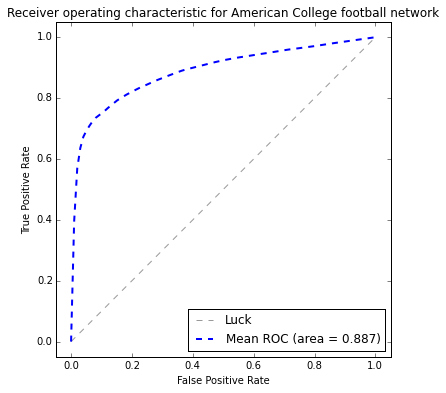

infos:
F1: 0.188 (+/- 0.031)
Precision: 0.109 (+/- 0.020)
Recall: 0.723 (+/- 0.045)
ROC_AUC: 0.830 (+/- 0.023)
Accuracy: 0.934 (+/- 0.012)
Avg_precision: 0.417 (+/- 0.026)


,name,value
0,SoI,0.181
1,RAI,0.137
2,PAI,0.135
3,HPI,0.111
4,KzI,0.076
5,ACT,0.075
6,RWR,0.070
7,CBL,0.040
8,JI,0.035
9,MFI,0.034


In [41]:
newman_football = nx.read_gml('./netws/newman/football/football.gml')
fixed_newman_football = nx.Graph(nx.convert_node_labels_to_integers(newman_football, first_label = 0))
run_folds_alg(fixed_newman_football, name = "American College football", fname = 'FB_test.png')

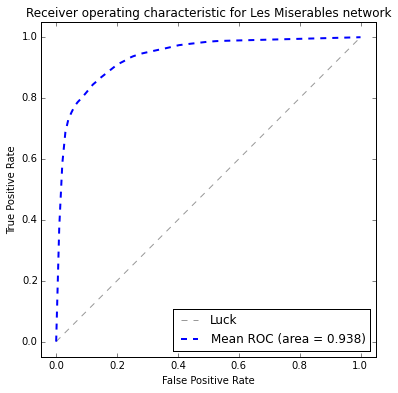

infos:
F1: 0.147 (+/- 0.022)
Precision: 0.081 (+/- 0.013)
Recall: 0.803 (+/- 0.071)
ROC_AUC: 0.857 (+/- 0.032)
Accuracy: 0.910 (+/- 0.019)
Avg_precision: 0.443 (+/- 0.035)


,name,value
0,AAI,0.183
1,HDI,0.174
2,ACT,0.105
3,SoI,0.081
4,PAI,0.076
5,RWR,0.076
6,SaI,0.062
7,LHN2,0.036
8,CN,0.035
9,JI,0.033


In [42]:
newman_lesmis = nx.read_gml('./netws/newman/lesmis/lesmis.gml')
fixed_newman_lesmis = nx.Graph(nx.convert_node_labels_to_integers(newman_lesmis, first_label = 0))
run_folds_alg(fixed_newman_lesmis, name = "Les Miserables", fname = 'LM_test.png')

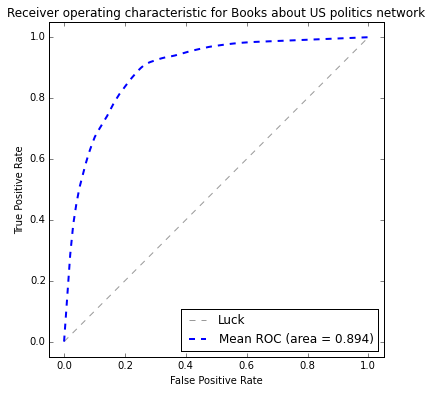

infos:
F1: 0.077 (+/- 0.006)
Precision: 0.041 (+/- 0.003)
Recall: 0.778 (+/- 0.049)
ROC_AUC: 0.808 (+/- 0.024)
Accuracy: 0.837 (+/- 0.011)
Avg_precision: 0.410 (+/- 0.025)


,name,value
0,SoI,0.151
1,RWR,0.108
2,PAI,0.087
3,HDI,0.077
4,CN,0.074
5,AAI,0.069
6,RAI,0.068
7,ACT,0.057
8,LHN1,0.051
9,KzI,0.050


In [43]:
newman_polbooks = nx.read_gml('./netws/newman/polbooks/polbooks.gml')
fixed_newman_polbooks = nx.Graph(nx.convert_node_labels_to_integers(newman_polbooks, first_label = 0))
run_folds_alg(fixed_newman_polbooks, name = "Books about US politics", fname = 'PB_test.png')

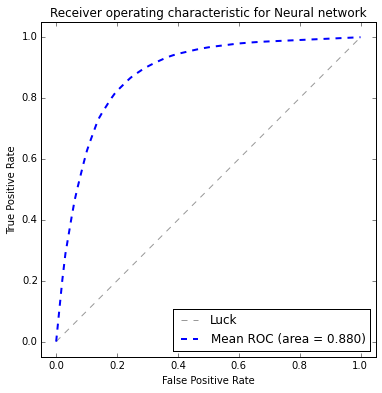

infos:
F1: 0.042 (+/- 0.002)
Precision: 0.022 (+/- 0.001)
Recall: 0.812 (+/- 0.018)
ROC_AUC: 0.812 (+/- 0.008)
Accuracy: 0.811 (+/- 0.008)
Avg_precision: 0.418 (+/- 0.009)


,name,value
0,SoI,0.162
1,PAI,0.151
2,AAI,0.146
3,HDI,0.104
4,RWR,0.093
5,ACT,0.062
6,CBL,0.055
7,KzI,0.051
8,LHN1,0.031
9,HPI,0.027


In [44]:
newman_celegansneural = nx.read_gml('./netws/newman/celegansneural/celegansneural.gml')
fixed_newman_celegansneural = nx.Graph(nx.convert_node_labels_to_integers(newman_celegansneural, first_label = 0))
run_folds_alg(fixed_newman_celegansneural, name = "Neural", fname = 'CN_test.png')

In [9]:
#rf
run_folds_alg(nx.karate_club_graph())

Done fold 1
Done fold 2
Done fold 3
Done fold 4
Done fold 5
Done fold 6
Done fold 7
Done fold 8
Done fold 9
Done fold 10
infos:
F1: 0.078 (+/- 0.022)
Precision: 0.042 (+/- 0.012)
Recall: 0.641 (+/- 0.189)
ROC_AUC: 0.698 (+/- 0.092)
Accuracy: 0.752 (+/- 0.057)
Avg_precision: 0.344 (+/- 0.097)


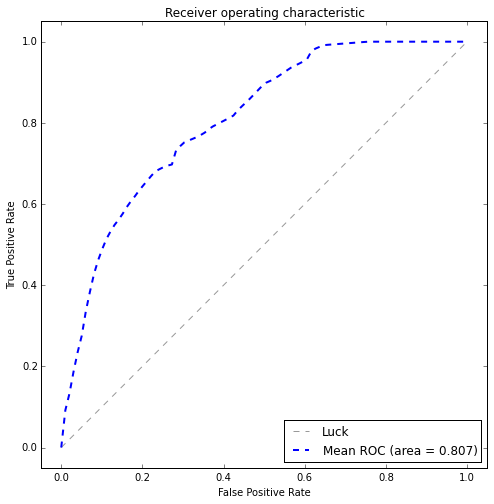

infos:
F1: 0.095 (+/- 0.032)
Precision: 0.051 (+/- 0.018)
Recall: 0.670 (+/- 0.172)
ROC_AUC: 0.732 (+/- 0.094)
Accuracy: 0.793 (+/- 0.030)
Avg_precision: 0.363 (+/- 0.093)


In [47]:
run_folds_alg(nx.karate_club_graph())

In [11]:
newman_adjnoun = nx.read_gml('./netws/newman/adjnoun/adjnoun.gml')
run_folds_alg(newman_adjnoun)

infos:
F1: 0.028 (+/- 0.003)
Precision: 0.014 (+/- 0.002)
Recall: 0.563 (+/- 0.077)
ROC_AUC: 0.637 (+/- 0.034)
Accuracy: 0.710 (+/- 0.026)
Avg_precision: 0.290 (+/- 0.039)


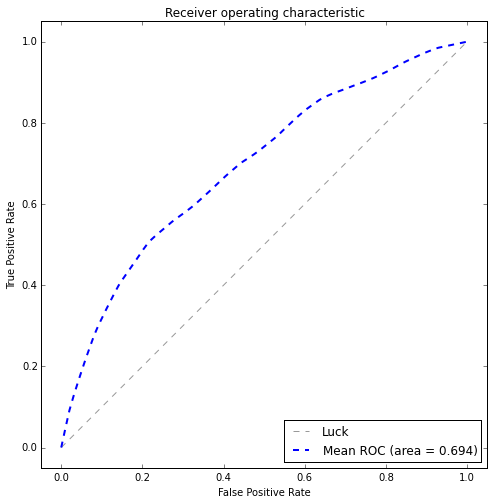

infos:
F1: 0.028 (+/- 0.002)
Precision: 0.014 (+/- 0.001)
Recall: 0.598 (+/- 0.060)
ROC_AUC: 0.646 (+/- 0.021)
Accuracy: 0.693 (+/- 0.025)
Avg_precision: 0.307 (+/- 0.030)


In [48]:
newman_adjnoun = nx.read_gml('./netws/newman/adjnoun/adjnoun.gml')
run_folds_alg(newman_adjnoun)

KeyboardInterrupt: 

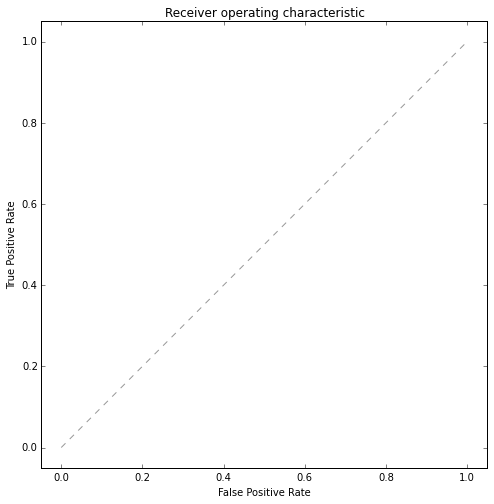

In [49]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
run_folds_alg(fixed_pajek_us_air)

In [13]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
run_folds_alg(fixed_pajek_us_air)

Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 1
Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 2
Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 3
Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 4
Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 5
Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 6
Done in fold 1
Done in

In [10]:
newman_celegansneural = nx.read_gml('./netws/newman/celegansneural/celegansneural.gml')
fixed_newman_celegansneural = nx.Graph(nx.convert_node_labels_to_integers(newman_celegansneural, first_label = 0))
run_folds_alg(fixed_newman_celegansneural)

infos:
F1: 0.042 (+/- 0.002)
Precision: 0.021 (+/- 0.001)
Recall: 0.806 (+/- 0.024)
ROC_AUC: 0.808 (+/- 0.012)
Accuracy: 0.810 (+/- 0.007)
Avg_precision: 0.414 (+/- 0.012)


In [9]:
newman_dolphins = nx.read_gml('./netws/newman/dolphins/dolphins.gml')
fixed_newman_dolphins = nx.Graph(nx.convert_node_labels_to_integers(newman_dolphins, first_label = 0))
run_folds_alg(fixed_newman_dolphins)

infos:
F1: 0.046 (+/- 0.008)
Precision: 0.024 (+/- 0.004)
Recall: 0.605 (+/- 0.081)
ROC_AUC: 0.688 (+/- 0.044)
Accuracy: 0.770 (+/- 0.029)
Avg_precision: 0.316 (+/- 0.042)


In [8]:
newman_football = nx.read_gml('./netws/newman/football/football.gml')
fixed_newman_football = nx.Graph(nx.convert_node_labels_to_integers(newman_football, first_label = 0))
run_folds_alg(fixed_newman_football)

infos:
F1: 0.203 (+/- 0.029)
Precision: 0.119 (+/- 0.020)
Recall: 0.710 (+/- 0.036)
ROC_AUC: 0.827 (+/- 0.018)
Accuracy: 0.942 (+/- 0.010)
Avg_precision: 0.416 (+/- 0.023)


In [7]:
newman_lesmis = nx.read_gml('./netws/newman/lesmis/lesmis.gml')
fixed_newman_lesmis = nx.Graph(nx.convert_node_labels_to_integers(newman_lesmis, first_label = 0))
run_folds_alg(fixed_newman_lesmis)

infos:
F1: 0.163 (+/- 0.031)
Precision: 0.091 (+/- 0.020)
Recall: 0.807 (+/- 0.081)
ROC_AUC: 0.863 (+/- 0.039)
Accuracy: 0.919 (+/- 0.017)
Avg_precision: 0.450 (+/- 0.042)


In [6]:
newman_polbooks = nx.read_gml('./netws/newman/polbooks/polbooks.gml')
fixed_newman_polbooks = nx.Graph(nx.convert_node_labels_to_integers(newman_polbooks, first_label = 0))
run_folds_alg(fixed_newman_polbooks)

infos:
F1: 0.075 (+/- 0.008)
Precision: 0.039 (+/- 0.004)
Recall: 0.757 (+/- 0.081)
ROC_AUC: 0.797 (+/- 0.039)
Accuracy: 0.837 (+/- 0.014)
Avg_precision: 0.399 (+/- 0.042)


In [ ]:
newman_netsci = nx.read_gml('./netws/newman/netscience/netscience.gml')
fixed_newman_netsci = nx.Graph(nx.convert_node_labels_to_integers(newman_netsci, first_label = 0))
run_folds_alg(fixed_newman_netsci)

Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 1
Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 2
Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold 9
Done in fold 10
Done fold 3
Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold

In [7]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))

In [ ]:
run_folds_alg(fixed_newman_netscience)

Done in fold 1
Done in fold 2
Done in fold 3
Done in fold 4
Done in fold 5
Done in fold 6
Done in fold 7
Done in fold 8
Done in fold

2126
332
